In [1]:
!nvidia-smi
from psutil import virtual_memory
print("Ram :", virtual_memory().total / 1e9, "GB")

# K80 < T4 < P100 < V100 < A100

Mon Nov 28 23:13:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# My library is very useful in this kind of image processing problem.
%%capture

!pip install nexd
from nexd import *
nd = Nexd()

In [3]:
print(nd.version)

1.3.2


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1 - Data


In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np

path_vanilla = "/content/drive/MyDrive/MVA/OBJECT/bird/bird_dataset"

if not os.path.exists(path_vanilla):
  !wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
  !unzip /content/bird_dataset.zip
  !rm /content/bird_dataset.zip
  path_vanilla = "bird_dataset"

Mounted at /content/drive


In [6]:
import random

species = [i.split(".")[-1] for i in nd.search_sub_folders(path=path_vanilla+"/train_images")]
print(f"There are {len(species)} species:")
for specie in species:
  print(" -", specie)

There are 20 species:
 - Yellow_headed_Blackbird
 - Bronzed_Cowbird
 - Brown_Creeper
 - Brewer_Blackbird
 - Black_billed_Cuckoo
 - Yellow_breasted_Chat
 - Fish_Crow
 - Red_winged_Blackbird
 - Gray_Catbird
 - Rusty_Blackbird
 - Groove_billed_Ani
 - Lazuli_Bunting
 - Bobolink
 - American_Crow
 - Indigo_Bunting
 - Painted_Bunting
 - Eastern_Towhee
 - Gray_crowned_Rosy_Finch
 - Yellow_billed_Cuckoo
 - Brandt_Cormorant


# 2 - Data processing


In [7]:
img_example = nd.im_load(path_vanilla + "/train_images/021.Eastern_Towhee/Eastern_Towhee_0117_22741.jpg")

## 2.1 - Bird segmentation

In [8]:
%%capture

!python -m pip install pyyaml==5.1

import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [9]:
%%capture

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

(356, 500, 3)


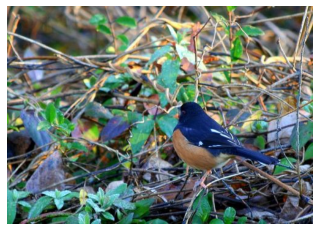

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(134, 172, 3)


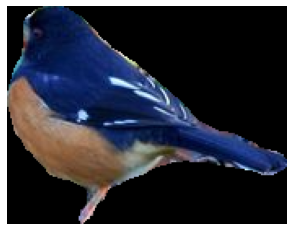

In [10]:
# we have choose to keep the background to not delete the context

def bird_segmentation(img):
  outputs = predictor(img)
  empty = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
    
  for idx in range(len(outputs["instances"].pred_classes)):
    if outputs["instances"].pred_classes[idx].tolist() == 14:
      new_box = outputs["instances"].pred_boxes[0].tensor.tolist()[0]
      empty[outputs["instances"].pred_masks[idx].tolist()]=[1,1,1]

  boxes = np.transpose(outputs["instances"].pred_boxes.tensor.tolist())
  box = [int(boxes[0].min()), int(boxes[1].min()), int(np.ceil(boxes[2].max())), int(np.ceil(boxes[3].max()))]
  return (img*empty)[box[1]:box[3], box[0]:box[2]]

nd.im_show(img_example, shape=True)
img_segmentation = nd.im_crop(bird_segmentation(img_example))
nd.im_show(img_segmentation, shape=True)

## 2.2 - Bounding boxes

We can obtain the Bounding box for each bird with Detectron2, YOLO or other models.

In [11]:
train_boxes = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/boxes/train_images")
val_boxes = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/boxes/val_images")
test_boxes = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/boxes/test_images")

In [12]:
path_vanilla.split("bird_dataset")[0]

'/content/drive/MyDrive/MVA/OBJECT/bird/'

bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0004_1528.jpg
[295  97 399 237]
[275  69 419 265]


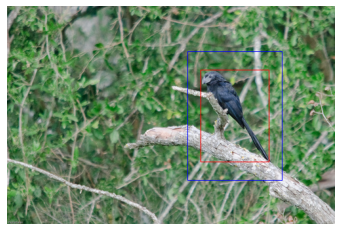

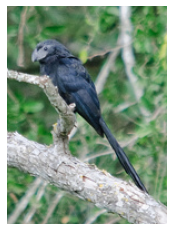

In [13]:
path_example, boxe_example = list(train_boxes.items())[1]
boxe_example = np.array(boxe_example[0]+boxe_example[1]).astype(int)
print(path_example)
print(boxe_example)

img_example = nd.im_load(path_vanilla.split("bird_dataset")[0] + path_example)

# it's possible to enlarge the bouding box
bigger_box = nd.rect_redim(boxe_example, 0.4)[0]
print(bigger_box)
img_example2 = nd.im_draw_rect(img_example, boxe_example, color=(255, 0, 0))
img_example2 = nd.im_draw_rect(img_example2, bigger_box, color=(0, 0, 255))
nd.im_show(img_example2)

extracting = img_example[bigger_box[1]:bigger_box[3], bigger_box[0]:bigger_box[2]]
nd.im_show(extracting)

## 2.3 - First Data Augment

It's better to do this to keep the geometry of each bird species. Indeed, a basic resize will just flat images.

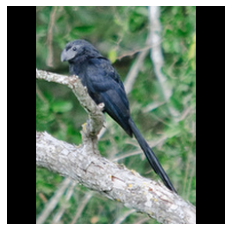

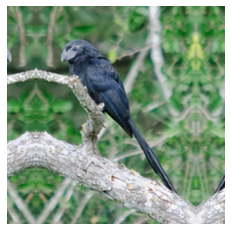

In [14]:
# we now can create square image with black or mirrored background

img_square = nd.im_square(extracting, mirror=True)

nd.im_show(nd.im_square(extracting))
nd.im_show(img_square)


## 2.4 - Other ideas

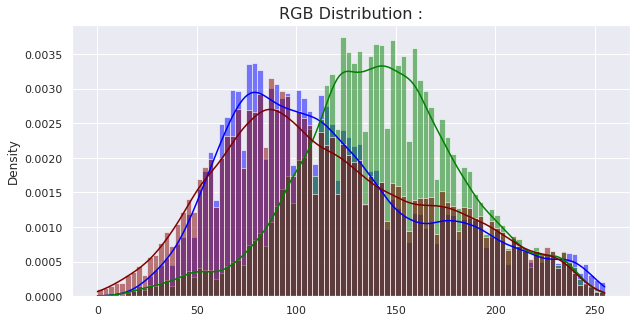

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

RGB_channels = [img_square[:, :, i].flatten() for i in range(3)]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('RGB Distribution :', fontsize=16)

sns.histplot(data=RGB_channels, palette=("maroon", "green", "blue"), kde=True, ax=ax, stat="density", legend=False)
plt.show()

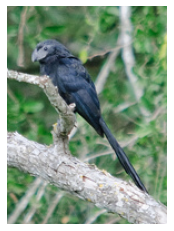

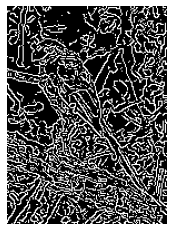

In [16]:
# the idea of edge detection can be interessant but here the color is important

import cv2

def canny_contour(image, sigma=0.01):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(image, lower, upper)

nd.im_show(extracting)
nd.im_show(canny_contour(extracting))

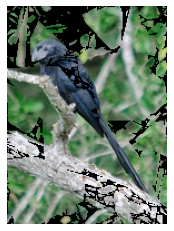

In [17]:
# but the edge detection can be used to delete some contours on the image

def canny_hull(canny, img):
    empty = np.zeros((canny.shape[0], canny.shape[1], 3), np.uint8)
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in sorted(contours, key=cv2.contourArea):
        hull = cv2.convexHull(cnt)
        empty = cv2.drawContours(empty, [hull], 0, (1,1,1), cv2.FILLED)
    return img*empty

nd.im_show(canny_hull(canny_contour(extracting), extracting))

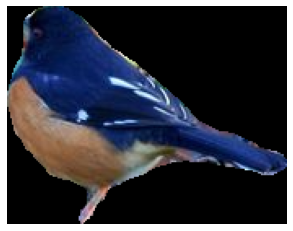

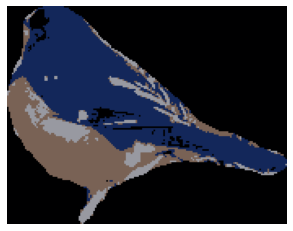

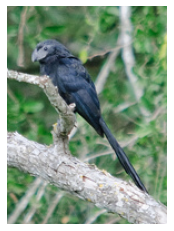

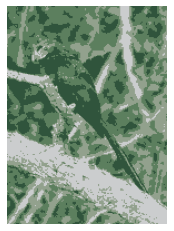

In [18]:
# the idea is to try to reduce the number of color
# it's interessant for colored bird

# in practice, we have choose to not segment each bird so, the cluster is not good
# because, cluster search to also be good with the background
# and we loose to much informations

def color_cluster(img, K_cluster=4, max_iter=10, epsilon=1.0, attempts=10):
    vectorized = np.float32(img.copy().reshape((-1,3)))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)
    _, label, center=cv2.kmeans(vectorized,
                                K_cluster,
                                None,
                                criteria,
                                attempts,
                                cv2.KMEANS_PP_CENTERS)
    return np.uint8(center)[label.flatten()].reshape((img.shape))

nd.im_show(img_segmentation)
nd.im_show(color_cluster(img_segmentation))

nd.im_show(extracting)
nd.im_show(color_cluster(extracting))

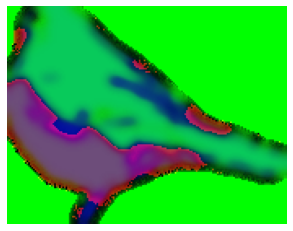

In [19]:
# we can try to select color in a HSV image

blur = cv2.blur(color_cluster(img_segmentation), (5,5))
blur0 = cv2.medianBlur(blur, 5)
blur1 = cv2.GaussianBlur(blur0, (5,5), 0)
blur2 = cv2.bilateralFilter(blur1, 9, 75, 75)
hsv = cv2.cvtColor(blur2, cv2.COLOR_BGR2HSV)
nd.im_show(hsv)

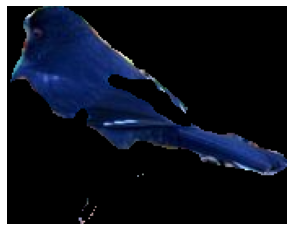

In [20]:
# and delete some colors
# but not relevant for this problem

low = np.array([0, 0, 0])
high = np.array([100, 255, 100])
mask = cv2.inRange(hsv, low, high)
nd.im_show(cv2.bitwise_and(img_segmentation, img_segmentation, mask=mask))

# 3 - Data Loader

## 3.1 - First Data Loader

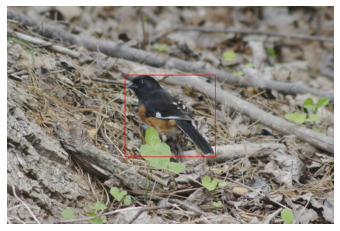

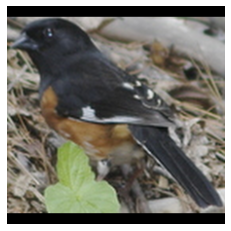

In [21]:
# here, we just extract the bounding box and put black background
# the size is (224, 224, 3)

path_example, boxe_example = random.choice(list(train_boxes.items()))
boxe_example = np.array(boxe_example[0]+boxe_example[1]).astype(int)

img_example = nd.im_load(path_vanilla.split("bird_dataset")[0] + path_example)
img_example2 = nd.im_draw_rect(img_example, boxe_example, color=(255, 0, 0))
nd.im_show(img_example2)

extracting = img_example[boxe_example[1]:boxe_example[3], boxe_example[0]:boxe_example[2]]
nd.im_show(nd.im_square(extracting, 224))

1082 images on the training dataset


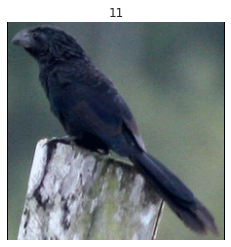

103 images on the validation dataset


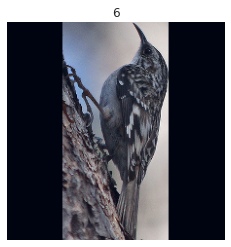

In [22]:
from torchvision import datasets, transforms, models
path = "/content/drive/MyDrive/MVA/OBJECT/bird/boxes"


transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/train_images', transform=transform_train),
    batch_size=64,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True
    )

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/val_images', transform=transform_test),
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True
    )

print(f"{len(train_loader.dataset)} images on the training dataset")
images, labels = next(iter(train_loader))
image = images[1].permute(1, 2, 0).numpy()
nd.im_show((image-image.min())/(image.max()-image.min()), title=str(labels[1].numpy()))

print(f"{len(val_loader.dataset)} images on the validation dataset")
images2, labels2 = next(iter(val_loader))
image2 = images2[1].permute(1, 2, 0).numpy()
nd.im_show((image2-image2.min())/(image2.max()-image2.min()), title=str(labels2[1].numpy()))

## 3.2 - Second Data Loader

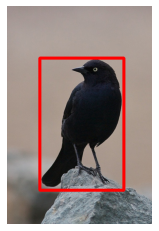

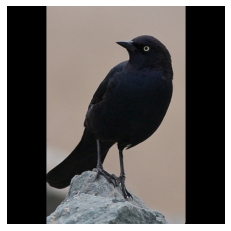

In [23]:
# here, we extract extended bounding box with a random values
# we rotate a little the image before extracting
# we create two sample of each image to enlarge the training dataset
# we create three sample of each image to enlarge the validation dataset
# the size is (448, 448, 3)

path_example, boxe_example = random.choice(list(train_boxes.items()))
boxe_example = np.array(boxe_example[0]+boxe_example[1]).astype(int)

img_example = nd.im_load(path_vanilla.split("bird_dataset")[0] + path_example)
nd.im_show(nd.im_draw_rect(img_example.copy(), boxe_example, color=(255, 0, 0), thickness=5))

img_example2 = nd.im_rotation(img_example, random.uniform(-15, 15), reshape=False)

boxe_example2 = nd.rect_redim(boxe_example, random.uniform(0.22, 0.3))[0]
boxe_example2 = np.array([max(boxe_example2[0], 0), max(boxe_example2[1], 0), min(boxe_example2[2], img_example.shape[1]), min(boxe_example2[3], img_example.shape[0])])

extracting = img_example2[boxe_example2[1]:boxe_example2[3], boxe_example2[0]:boxe_example2[2]]

nd.im_show(nd.im_square(extracting, 448))

3246 images on the training dataset


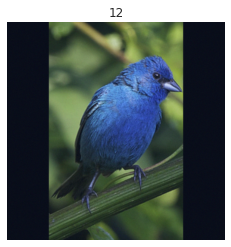

309 images on the validation dataset


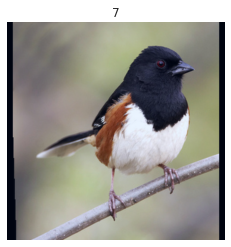

In [24]:
path = "/content/drive/MyDrive/MVA/OBJECT/bird/boxes2"

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.01):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

transform_train2 = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.01),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test2 = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader2 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/train_images', transform=transform_train2),
    batch_size=64,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True
    )

val_loader2 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/val_images', transform=transform_test2),
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True
    )

print(f"{len(train_loader2.dataset)} images on the training dataset")
fine_images, fine_labels = next(iter(train_loader2))
fine_image = fine_images[1].permute(1, 2, 0).numpy()
nd.im_show((fine_image-fine_image.min())/(fine_image.max()-fine_image.min()), title=str(fine_labels[1].numpy()))

print(f"{len(val_loader2.dataset)} images on the validation dataset")
fine_images2, fine_labels2 = next(iter(val_loader2))
fine_image2 = fine_images2[1].permute(1, 2, 0).numpy()
nd.im_show((fine_image2-fine_image2.min())/(fine_image2.max()-fine_image2.min()), title=str(fine_labels2[1].numpy()))

# 4 - Model

We will use three very know models with differents architectures to compare the performance.

Indeed, these models have been trained to extract information from images. We can therefore specialize them for our problem.

In [25]:
from torch import nn

## 4.1 - ResNet-50

In [26]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V1")
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 20)
        )
        
        for param in self.model.parameters():
          param.requires_grad = False
        
        for param in self.model.fc.parameters():
          param.requires_grad = True
          
    def forward(self, val):
        return self.model(val)
model_resnet50 = ResNet50()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## 4.2 - VGG19

In [27]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.base = models.vgg19(weights="VGG19_Weights.IMAGENET1K_V1")

        for param in self.base.parameters():
          param.requires_grad = False

        num_ftrs = self.base.classifier[-1].out_features
        self.model = nn.Sequential(self.base, 
                              nn.Linear(num_ftrs, 512),
                              nn.Linear(512, 20))
          
    def forward(self, val):
        return self.model(val)
model_vgg19 = VGG19()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## 4.3 - ViT_H_14

In [28]:
class ViT_H14(nn.Module):
    def __init__(self):
        super(ViT_H14, self).__init__()
        self.base = models.vit_h_14(weights="ViT_H_14_Weights.IMAGENET1K_SWAG_E2E_V1")

        for param in self.base.parameters():
          param.requires_grad = False
        
        for param in self.base.heads.head.parameters():
          param.requires_grad = True

        num_ftrs = self.base.heads.head.out_features
        self.model = nn.Sequential(self.base, 
                              nn.Linear(num_ftrs, 512),
                              nn.Linear(512, 20))
          
    def forward(self, val):
        return self.model(val)

model_vit_h_14 = ViT_H14()

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to /root/.cache/torch/hub/checkpoints/vit_h_14_swag-80465313.pth


  0%|          | 0.00/2.36G [00:00<?, ?B/s]

# 5 - Training

In [29]:
from tqdm.autonotebook import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

def train(model, epochs, train_loader, val_loader, history, lr=1e-4, changements=[], title=""):

  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)  
  loss_fn = nn.CrossEntropyLoss(reduction='mean')

  [train_loss, val_loss, train_accuracy, val_accuracy] = history
  model.to(device)

  for epoch in range(1, epochs+1):

    total_loss = 0
    total_acc = 0

    # ----------------- TRAINING  --------------------
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader))
    model.train()
    for batch, (data, target) in progress:
      data, target = data.to(device), target.to(device)
      model.zero_grad()
      output = model(data)
      p_loss = loss_fn(output, target)
      p_loss.backward()
      optimizer.step()

      _, predicted = torch.max(output, 1) 
      total_loss += p_loss.item()
      total_acc += accuracy_score(target.cpu(), predicted.cpu())
      progress.set_description("Loss: {:.4f}".format(total_loss/(batch+1)))
    
    train_loss.append(total_loss/len(train_loader))
    train_accuracy.append(total_acc/len(train_loader))
    # ------------------------------------------------



    # ----------------- VALIDATION  --------------------
    v_loss = 0
    accuracy_temp = []
    
    model.eval()
    with torch.no_grad():

      for batch, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        v_loss += loss_fn(output, target)
        
        _, predicted = torch.max(output, 1) 

        accuracy_temp.append(accuracy_score(target.cpu(), predicted.cpu()))

      val_accuracy.append(sum(accuracy_temp)/len(val_loader))
      val_loss.append((v_loss/len(val_loader)).item())
    # ------------------------------------------------
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    
    colors = ["red", "blue"]
    clear_output(wait=True)
    X = range(len(train_loss))
  
    plt.subplot(121)
    plt.plot(X, train_loss, color=colors[0], label='train_loss')
    plt.plot(X, val_loss, color=colors[1], label='val_loss')
    plt.title("Evolution of loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    for val in changements:
      plt.axvline(x=val, color='green', linestyle='--')
    plt.legend()

    plt.subplot(122)
    plt.plot(X, train_accuracy, color=colors[0], label='train_accuracy')
    plt.plot(X, val_accuracy, color=colors[1], label='val_accuracy')
    plt.title("Evolution of accuracy")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    for val in changements:
      plt.axvline(x=val, color='green', linestyle='--')
    plt.legend()
    plt.show()

    return model, [train_loss, val_loss, train_accuracy, val_accuracy]

## 5.1 - ResNet-50

In [30]:
model_resnet50.load_state_dict(torch.load("/content/drive/MyDrive/MVA/OBJECT/bird/resnet50_600_epochs.pth"))
[train_loss_resnet50, val_loss_resnet50, train_accuracy_resnet50, val_accuracy_resnet50] = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/resnet50_600_epochs")

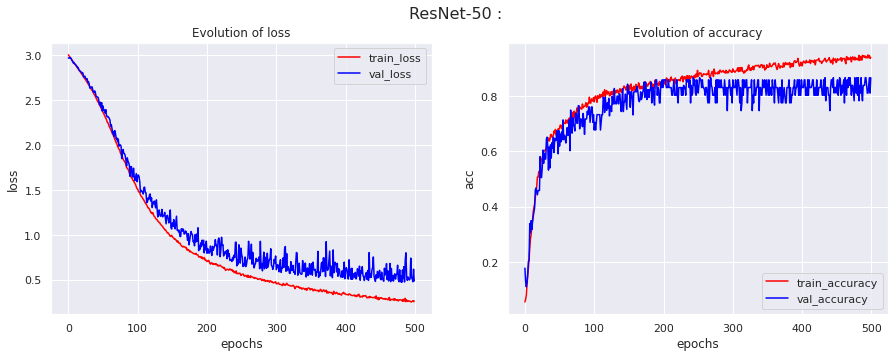

In [31]:
plt.figure(figsize=(15, 5))
plt.suptitle('ResNet-50 :', fontsize=16)

colors = ["red", "blue"]
clear_output(wait=True)
X = range(len(train_loss_resnet50[:500]))

plt.subplot(121)
plt.plot(X, train_loss_resnet50[:500], color=colors[0], label='train_loss')
plt.plot(X, val_loss_resnet50[:500], color=colors[1], label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)
plt.plot(X, train_accuracy_resnet50[:500], color=colors[0], label='train_accuracy')
plt.plot(X, val_accuracy_resnet50[:500], color=colors[1], label='val_accuracy')
plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

## 5.2 - VGG19

In [32]:
model_vgg19.load_state_dict(torch.load("/content/drive/MyDrive/MVA/OBJECT/bird/vgg19_750_epochs.pth"))
[train_loss_vgg19, val_loss_vgg19, train_accuracy_vgg19, val_accuracy_vgg19] = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/vgg19_750_epochs")

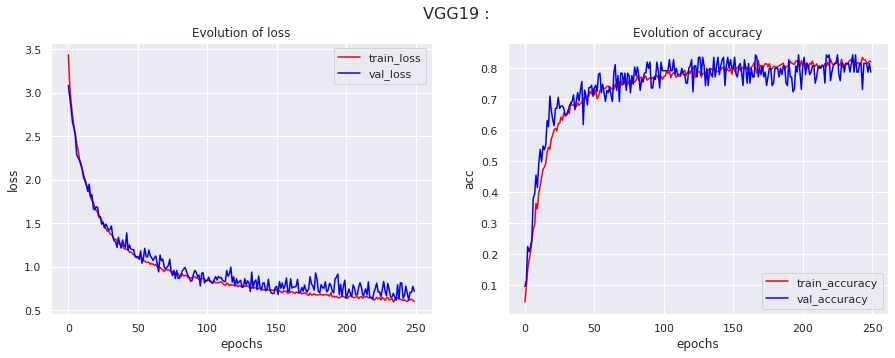

In [33]:
plt.figure(figsize=(15, 5))
plt.suptitle('VGG19 :', fontsize=16)

colors = ["red", "blue"]
clear_output(wait=True)
X = range(len(train_loss_vgg19[:250]))

plt.subplot(121)
plt.plot(X, train_loss_vgg19[:250], color=colors[0], label='train_loss')
plt.plot(X, val_loss_vgg19[:250], color=colors[1], label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)
plt.plot(X, train_accuracy_vgg19[:250], color=colors[0], label='train_accuracy')
plt.plot(X, val_accuracy_vgg19[:250], color=colors[1], label='val_accuracy')
plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

## 5.3 - ViT_H_14

Directly train with the second Data Loader

In [34]:
model_vit_h_14.load_state_dict(torch.load("/content/drive/MyDrive/MVA/OBJECT/bird/vit_h_14_70_epochs.pth"))
[train_loss_vit_h_14, val_loss_vit_h_14, train_accuracy_vit_h_14, val_accuracy_vit_h_14] = nd.load("/content/drive/MyDrive/MVA/OBJECT/bird/vit_h_14_70_epochs")

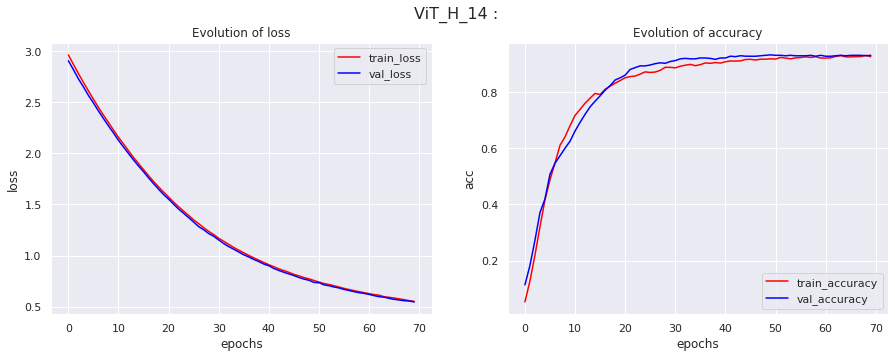

In [35]:
plt.figure(figsize=(15, 5))
plt.suptitle('ViT_H_14 :', fontsize=16)

colors = ["red", "blue"]
clear_output(wait=True)
X = range(len(train_loss_vit_h_14[:500]))

plt.subplot(121)
plt.plot(X, train_loss_vit_h_14[:500], color=colors[0], label='train_loss')
plt.plot(X, val_loss_vit_h_14[:500], color=colors[1], label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)
plt.plot(X, train_accuracy_vit_h_14[:500], color=colors[0], label='train_accuracy')
plt.plot(X, val_accuracy_vit_h_14[:500], color=colors[1], label='val_accuracy')
plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

# 6 - Fine Tuning

We can continue to train the models that did not perform well with the data loader2 which has more and larger images and makes more modifications.

We unlocked more layers for training with a lower learning rate.

## 6.1 ResNet-50

In [36]:
for param in model_resnet50.model.layer4[2].parameters():
  param.requires_grad = True

for name, param in model_resnet50.named_parameters():
  if param.requires_grad:
    print(name)

model.layer4.2.conv1.weight
model.layer4.2.bn1.weight
model.layer4.2.bn1.bias
model.layer4.2.conv2.weight
model.layer4.2.bn2.weight
model.layer4.2.bn2.bias
model.layer4.2.conv3.weight
model.layer4.2.bn3.weight
model.layer4.2.bn3.bias
model.fc.0.weight
model.fc.0.bias
model.fc.1.weight
model.fc.1.bias
model.fc.2.weight
model.fc.2.bias


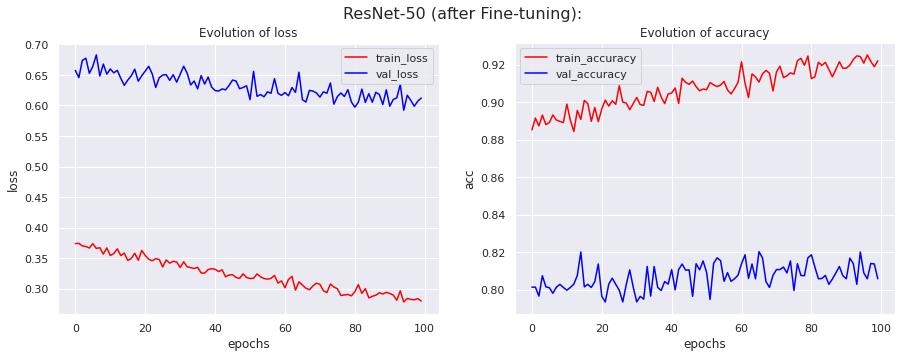

In [37]:
plt.figure(figsize=(15, 5))
plt.suptitle('ResNet-50 (after Fine-tuning):', fontsize=16)

colors = ["red", "blue"]
clear_output(wait=True)
X = range(len(train_loss_resnet50[500:]))

plt.subplot(121)
plt.plot(X, train_loss_resnet50[500:], color=colors[0], label='train_loss')
plt.plot(X, val_loss_resnet50[500:], color=colors[1], label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)
plt.plot(X, train_accuracy_resnet50[500:], color=colors[0], label='train_accuracy')
plt.plot(X, val_accuracy_resnet50[500:], color=colors[1], label='val_accuracy')
plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

plt.show()

## 6.2 - VGG19

In [38]:
for param in model_vgg19.model[0].classifier.parameters():
  param.requires_grad = True

for name, param in model_vgg19.named_parameters():
  if param.requires_grad:
    print(name)

base.classifier.0.weight
base.classifier.0.bias
base.classifier.3.weight
base.classifier.3.bias
base.classifier.6.weight
base.classifier.6.bias
model.1.weight
model.1.bias
model.2.weight
model.2.bias


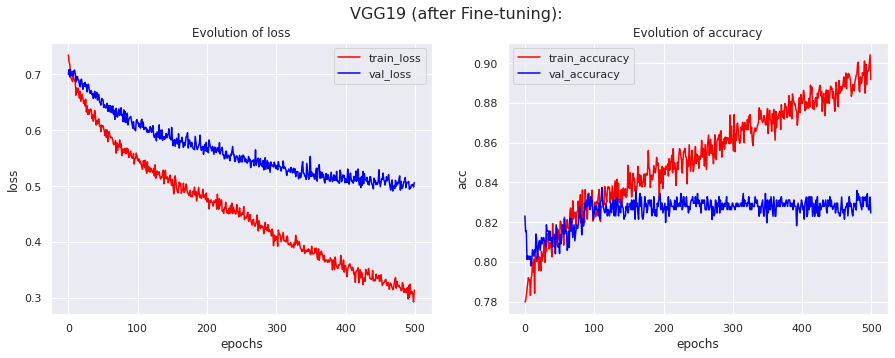

In [39]:
plt.figure(figsize=(15, 5))
plt.suptitle('VGG19 (after Fine-tuning):', fontsize=16)

colors = ["red", "blue"]
clear_output(wait=True)
X = range(len(train_loss_vgg19[250:]))

plt.subplot(121)
plt.plot(X, train_loss_vgg19[250:], color=colors[0], label='train_loss')
plt.plot(X, val_loss_vgg19[250:], color=colors[1], label='val_loss')
plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(122)
plt.plot(X, train_accuracy_vgg19[250:], color=colors[0], label='train_accuracy')
plt.plot(X, val_accuracy_vgg19[250:], color=colors[1], label='val_accuracy')
plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

plt.show()

# 7 - Analyze

## 7.1 - Evolution of Loss

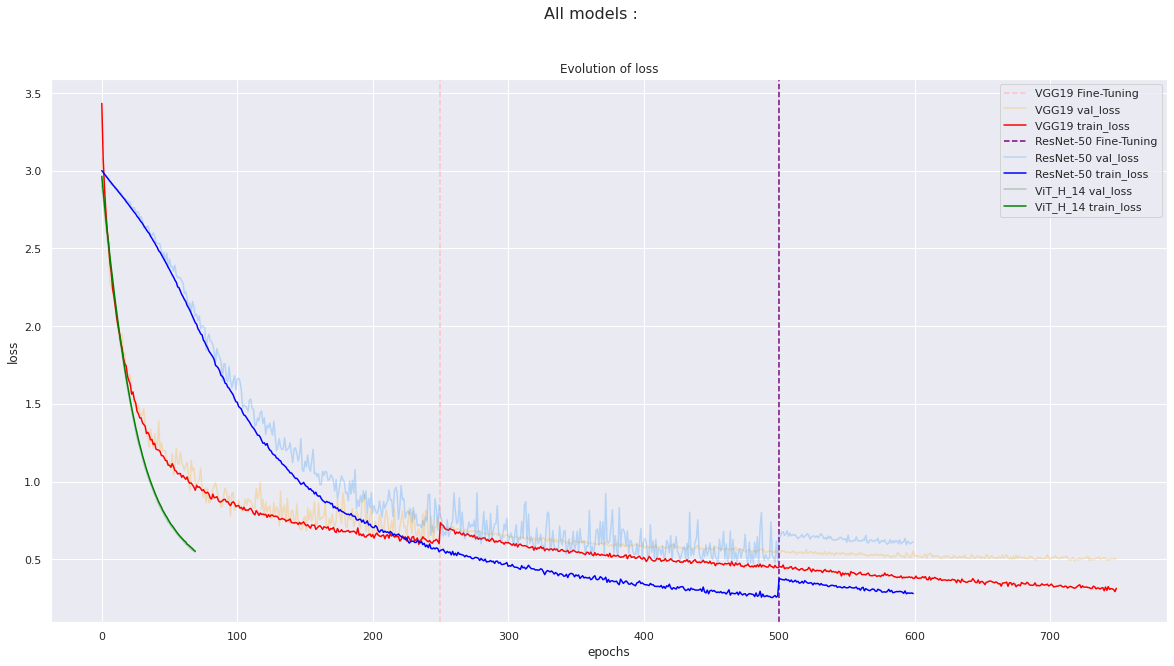

In [40]:
plt.figure(figsize=(20, 10))
plt.suptitle('All models :', fontsize=16)
colors = nd.rgb_colors()

clear_output(wait=True)
plt.axvline(x=250, color=[val/255 for val in colors["pink"]]+[1], linestyle='--', label="VGG19 Fine-Tuning")
plt.plot(range(len(val_loss_vgg19)), val_loss_vgg19, color=[val/255 for val in colors["orange"]]+[0.25], label='VGG19 val_loss')
plt.plot(range(len(train_loss_vgg19)), train_loss_vgg19, color=[val/255 for val in colors["red"]]+[1], label='VGG19 train_loss')

plt.axvline(x=500, color=[val/255 for val in colors["purple"]]+[1], linestyle='--', label="ResNet-50 Fine-Tuning")
plt.plot(range(len(val_loss_resnet50)), val_loss_resnet50, color=[val/255 for val in colors["dodger_blue"]]+[0.25], label='ResNet-50 val_loss')
plt.plot(range(len(train_loss_resnet50)), train_loss_resnet50, color=[val/255 for val in colors["blue"]]+[1], label='ResNet-50 train_loss')

plt.plot(range(len(val_loss_vit_h_14)), val_loss_vit_h_14, color=[val/255 for val in colors["dark_green"]]+[0.25], label='ViT_H_14 val_loss')
plt.plot(range(len(train_loss_vit_h_14)), train_loss_vit_h_14, color=[val/255 for val in colors["green"]]+[1], label='ViT_H_14 train_loss')

plt.title("Evolution of loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

## 7.2 - Evolution of Accuracy

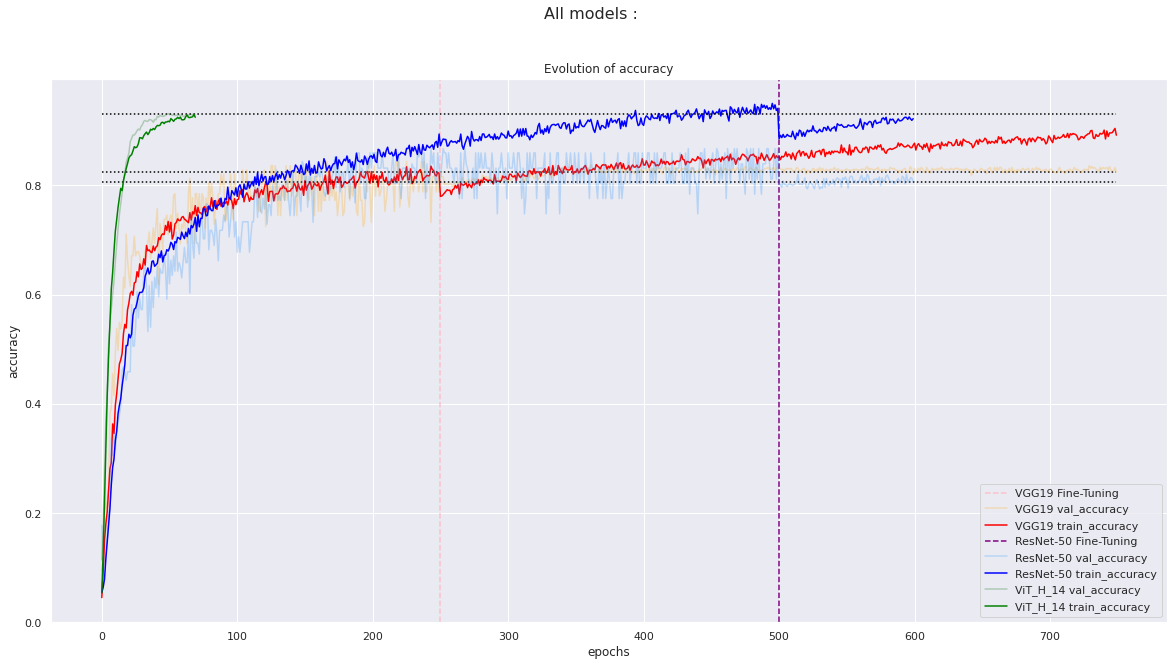

In [41]:
plt.figure(figsize=(20, 10))
plt.suptitle('All models :', fontsize=16)
colors = nd.rgb_colors()

clear_output(wait=True)
plt.plot(range(750), [val_accuracy_vgg19[-1] for _ in range(750)], color=[val/255 for val in colors["black"]]+[1], ls=('dotted'))
plt.axvline(x=250, color=[val/255 for val in colors["pink"]]+[1], linestyle='--', label="VGG19 Fine-Tuning")
plt.plot(range(len(val_accuracy_vgg19)), val_accuracy_vgg19, color=[val/255 for val in colors["orange"]]+[0.25], label='VGG19 val_accuracy')
plt.plot(range(len(train_accuracy_vgg19)), train_accuracy_vgg19, color=[val/255 for val in colors["red"]]+[1], label='VGG19 train_accuracy')


plt.plot(range(750), [val_accuracy_resnet50[-1] for _ in range(750)], color=[val/255 for val in colors["black"]]+[1], ls=('dotted'))
plt.axvline(x=500, color=[val/255 for val in colors["purple"]]+[1], linestyle='--', label="ResNet-50 Fine-Tuning")
plt.plot(range(len(val_accuracy_resnet50)), val_accuracy_resnet50, color=[val/255 for val in colors["dodger_blue"]]+[0.25], label='ResNet-50 val_accuracy')
plt.plot(range(len(train_accuracy_resnet50)), train_accuracy_resnet50, color=[val/255 for val in colors["blue"]]+[1], label='ResNet-50 train_accuracy')



plt.plot(range(750), [val_accuracy_vit_h_14[-1] for _ in range(750)], color=[val/255 for val in colors["black"]]+[1], ls=('dotted'))
plt.plot(range(len(val_accuracy_vit_h_14)), val_accuracy_vit_h_14, color=[val/255 for val in colors["dark_green"]]+[0.25], label='ViT_H_14 val_accuracy')
plt.plot(range(len(train_accuracy_vit_h_14)), train_accuracy_vit_h_14, color=[val/255 for val in colors["green"]]+[1], label='ViT_H_14 train_accuracy')


plt.title("Evolution of accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# 8 - Evaluation

In [42]:
all_models = [model_resnet50, model_vgg19, model_vit_h_14]

## 8.1 - Validation Weighted Average

309 images on the validation dataset
(518, 518, 3)


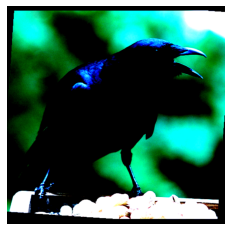

309 images on the validation dataset


(224, 224, 3)


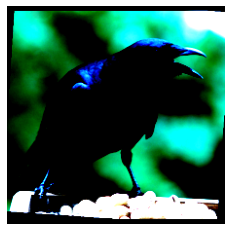

In [122]:
path = "/content/drive/MyDrive/MVA/OBJECT/bird/boxes2"

transform_test1 = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_loader1 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/val_images', transform=transform_test1),
    batch_size=1
    )

val_loader2 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/val_images', transform=transform_test2),
    batch_size=1
    )
print(f"{len(val_loader1.dataset)} images on the validation dataset")
fine_images2, fine_labels2 = next(iter(val_loader1))
fine_image2 = fine_images2[0].permute(1, 2, 0).numpy()
nd.im_show(fine_image2, shape=True)

print(f"{len(val_loader2.dataset)} images on the validation dataset")
fine_images2, fine_labels2 = next(iter(val_loader2))
fine_image2 = fine_images2[0].permute(1, 2, 0).numpy()
nd.im_show(fine_image2, shape=True)

In [130]:
coef1 = val_accuracy_resnet50[-1]
coef2 = val_accuracy_vgg19[-1]
coef3 = val_accuracy_vit_h_14[-1]
print(coef1, coef2, coef3)

0.8058035714285714 0.8245535714285713 0.9296130952380952


In [132]:
model1 = all_models[0]
model2 = all_models[1]
model3 = all_models[2]

model1.to(device)
model2.to(device)
model3.to(device)

model1.eval()
model2.eval()
model3.eval()

P1 = []
P2 = []
P3 = []
T1 = []
T2 = []

with torch.no_grad():
  for batch, (data, target) in tqdm(enumerate(val_loader2), total=len(val_loader2)):
    data, target = data.to(device), target.to(device)
    T1.append(target[0].cpu().numpy())
    
    output1 = model1(data)
    P1.append(output1[0].cpu().numpy())

    output2 = model2(data)
    P2.append(output2[0].cpu().numpy())

with torch.no_grad():
  for batch, (data, target) in tqdm(enumerate(val_loader1), total=len(val_loader1)):
    data, target = data.to(device), target.to(device)
    T2.append(target[0].cpu().numpy())
    
    output3 = model3(data)
    P3.append(output3[0].cpu().numpy())

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

In [ ]:
coef1 = val_accuracy_resnet50[-1]
coef2 = val_accuracy_vgg19[-1]
coef3 = val_accuracy_vit_h_14[-1]
print(coef1, coef2, coef3)

In [147]:
P4 = []
for i in range(len(P3)):
  P4.append(np.argmax(P1[i]*coef1 + P2[i]*coef2 + P3[i]*coef3))

In [148]:
print("ResNet-50:", accuracy_score(T1, [np.argmax(val) for val in P1]))
print("VGG19:", accuracy_score(T1, [np.argmax(val) for val in P2]))
print("ViT_H_14:", accuracy_score(T1, [np.argmax(val) for val in P3]))
print("Average weighted by val_acc:", accuracy_score(T1, P4))

ResNet-50: 0.8317152103559871
VGG19: 0.8284789644012945
ViT_H_14: 0.9288025889967637
Average weighted by val_acc: 0.9093851132686084


## 8.2 Predicted Test images

In [170]:
path = "/content/drive/MyDrive/MVA/OBJECT/bird/boxes"

transform1 = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

loader1 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/test_images', transform=transform1),
    batch_size=1
    )

loader2 = torch.utils.data.DataLoader(
    datasets.ImageFolder(path+'/test_images', transform=transform2),
    batch_size=1
    )
print(f"{len(loader1.dataset)} images on the test dataset")
print(f"{len(loader2.dataset)} images on the test dataset")

517 images on the test dataset
517 images on the test dataset


In [172]:
R1 = []
R2 = []
R3 = []

with torch.no_grad():
  for batch, (data, target) in tqdm(enumerate(loader2), total=len(loader2)):
    data, target = data.to(device), target.to(device)
    
    output1 = model1(data)
    R1.append(output1[0].cpu().numpy())

    output2 = model2(data)
    R2.append(output2[0].cpu().numpy())

with torch.no_grad():
  for batch, (data, target) in tqdm(enumerate(loader1), total=len(loader1)):
    data, target = data.to(device), target.to(device)
    
    output3 = model3(data)
    R3.append(output3[0].cpu().numpy())

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

In [179]:
R4 = []
for i in range(len(R3)):
  R4.append(np.argmax(R1[i]*coef1 + R2[i]*coef2 + R3[i]*coef3))

In [218]:
# to have same output sigifications as Kaggle
dic1 = datasets.ImageFolder(path+'/train_images', transform=transform_test).class_to_idx
dic2 = datasets.ImageFolder(path_vanilla+"/train_images", transform=transform_test).class_to_idx

dic3 = {}

for key, val in dic2.items():
  dic3[val] = dic1[key.split(".")[-1]]
dic3 = {i:j for j,i in dic3.items()}

In [ ]:
name_list = nd.list_ext("/content/drive/MyDrive/MVA/OBJECT/bird/bird_dataset/test_images/mistery_category")
name_list.sort()

R3_bis = [np.argmax(val) for val in R3]
output_file = open("result_vit.csv", "w")
output_file.write("Id,Category\n")
for i in range(len(name_list)):
  output_file.write("%s,%d\n" % (name_list[i][:-4], dic3[R3_bis[i]]))
output_file.close()

output_file = open("result_all.csv", "w")
output_file.write("Id,Category\n")
for i in range(len(name_list)):
  output_file.write("%s,%d\n" % (name_list[i][:-4], dic3[R4[i]]))
output_file.close()